<a href="https://colab.research.google.com/github/eshaghjahangiri/quantum-machine-learning/blob/main/Reinforcement_Learning_Lab_2ndPart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Portfolio Management using Reinforcement Learning Algorithms**

In the previous session, we used the SARSA and Q-Learning methods to teach the agent how to navigate the **FROZEN LAKE**.

**BUT, what if the state and/or action space are continuous?**

---

## **The Challenge**

For example, in the portfolio management problem where the environment is the *Financial Market*, you need to allocate a portfolio to invest in each stock, and this amount is continuous (e.g., 0.01, 0.5, 0.42, ...). Or consider the state space of a financial market, which can include stock prices, volume of stocks traded, technical indicators, etc., all of which are not discrete!

Using a Q-table to update the Q-value of each state-action pair is no longer feasible for problems where at least one of the state or action spaces is continuous.

**So, what should we do?**

---

## **Solution: Function Approximation Methods**

We turn to function approximation methods to estimate the Q-values or policies. These methods can handle continuous spaces by approximating the Q-values or policy using parameterized functions like neural networks. Some popular approaches include:

### **Deep Q-Learning (DQN):**
Extends Q-Learning by using a neural network to approximate the Q-value function. This method is particularly useful when dealing with large or continuous state spaces.

### **Policy Gradient Methods:**
Instead of learning a value function, these methods directly parameterize the policy and optimize it using gradient ascent. Examples include **REINFORCE**, **Actor-Critic**, and **Proximal Policy Optimization (PPO)**.

### **Actor-Critic Methods:**
Combine the benefits of value-based and policy-based methods. The actor decides which action to take, and the critic evaluates how good the action was, using a value function. Examples include **A2C (Advantage Actor-Critic)** and **DDPG (Deep Deterministic Policy Gradient)**.

### **Continuous Action Spaces:**
Techniques like **DDPG**, **Twin Delayed DDPG (TD3)**, and **Soft Actor-Critic (SAC)** are specifically designed to handle continuous action spaces effectively.

By leveraging these advanced reinforcement learning algorithms, we can tackle complex financial environments where decisions must be made in continuous spaces.

---

## **Let's Implement PPO for Portfolio Management**

We don't need to write advanced Deep RL algorithms from scratch!

We will use the **Stable Baselines3 (SB3)** library, which provides reliable implementations of reinforcement learning algorithms.

### **First Step: Define the Environment**

YES! Define the environment, which is the stock market. Let's do this with the help of **Open AI Gymnasium**.

---

Let's get started and build an agent who can dynamically manage a financial portfolio using **PPO**!


In [1]:
!pip install gymnasium
!pip install stable-baselines3[extra]
!pip install 'shimmy>=0.2.1'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gym.utils import seeding
from gym import spaces
from gym import Env
import math
import time

from stable_baselines3 import PPO, SAC, A2C, TD3

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

## Define an Environment

### How Should an Agent Choose an Action?

An action in this context is a vector of weights for the allocation of each stock. We need to determine what kind of information we want to provide to the agent. Let's imagine a portfolio manager who decides how much money to allocate to each stock based on their historical performance.

### Information to Provide to the Agent:

Let's give the agent the **Adjusted Close Price** of each stock at each date. Based on this information, the agent will choose how to allocate the capital among all stocks.

---

By providing the adjusted close prices, the agent can learn from historical data and make informed decisions on capital allocation to maximize returns. Let's proceed to set up the environment and define the necessary parameters for our agent.


In [3]:
initial_capital = 100  # initial money
transaction_cost = 0.001
# 10 shares per trade-share
shares_trade = 10

In [4]:
class StockMarket(Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, day=0, initial=True):

        super(StockMarket, self).__init__()

        self.df = df
        self.day = day
        self.initial = initial

        self.stock_num = self.df.shape[1]  # number of stocks in the portfolio

        self.action_space = spaces.Box(low=0, high=1, shape=(self.stock_num,))  # Action Space
        self.observation_space = spaces.Box(low=-1, high=np.inf, shape=(2 * self.stock_num + 1,))  # State Space

        self.data = self.df.iloc[self.day, :]

        self.terminal = False

        self.state = [initial_capital] + self.data.values.tolist() + [0] * self.stock_num  # Initial State

        self.reward = 0  # Initial Reward

        self.balance_memory = [initial_capital]  # Memorize the total balance
        self.actions_memory = [[1 / self.stock_num] * self.stock_num]

        self.seed(0)

    def sell_stock(self, index, action):

        action = np.floor(action)

        if self.state[index + self.stock_num + 1] > 0:
            self.state[0] += self.state[index + 1] * min(abs(action), self.state[index + self.stock_num + 1]) * (
                        1 - transaction_cost)
            self.state[index + self.stock_num + 1] -= min(abs(action), self.state[index + self.stock_num + 1])

        else:
            pass

    def buy_stock(self, index, action):

        action = np.floor(action)

        self.state[0] -= self.state[index + 1] * action * (1 + transaction_cost)

        self.state[index + self.stock_num + 1] += action

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1

        if self.terminal:
            return self.state, self.reward, self.terminal, {}

        else:
            actions = actions * shares_trade

            initial_total_asset = self.state[0] + \
                                  sum(np.array(self.state[1:(self.stock_num + 1)]) * np.array(
                                      self.state[(self.stock_num + 1):(self.stock_num * 2 + 1)]))
            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                self.sell_stock(index, actions[index])

            for index in buy_index:
                self.buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.iloc[self.day, :]

            self.state = [self.state[0]] + self.data.values.tolist() + \
                         list(self.state[(self.stock_num + 1):(self.stock_num * 2 + 1)])

            final_total_asset = self.state[0] + \
                                sum(np.array(self.state[1:(self.stock_num + 1)]) * np.array(
                                    self.state[(self.stock_num + 1):(self.stock_num * 2 + 1)]))

            self.reward = final_total_asset - initial_total_asset
            weights = self.normalization(np.array(self.state[(self.stock_num + 1):(self.stock_num * 2 + 1)]))

            self.actions_memory.append(weights.tolist())
            self.reward = self.reward

        return self.state, self.reward, self.terminal, {}


    def reset(self):

        self.day = 0
        self.data = self.df.iloc[self.day, :]
        self.terminal = False

        self.actions_memory = [[1 / self.stock_num] * self.stock_num]  # memorize all weights changes

        self.state = [initial_capital] + self.data.values.tolist() + [0] * self.stock_num

        self.seed(0)

        return self.state

    def normalization(self, actions):
        normalized_actions = actions / (np.sum(actions) + 1e-15)
        return normalized_actions

    def save_action_memory(self):
        return self.actions_memory

    def render(self, close=False):
        return self.state

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


def train(algorithm, policy, env_traian, timesteps, seed=None, save=True):
    start = time.time()
    if algorithm == "PPO":
        model = PPO(policy, env_traian, verbose=0, seed=seed)
    elif algorithm == "A2C":
        model = A2C(policy, env_traian, verbose=0, seed=seed)
    elif algorithm == "SAC":
        model = SAC(policy, env_traian, verbose=0, seed=seed)
    elif algorithm == "TD3":
        model = TD3(policy, env_traian, verbose=0, seed=seed)

    model.learn(total_timesteps=timesteps)
    end = time.time()

    if save == True:
        model.save("results/" + algorithm + "_" + str(timesteps) + "_model")
    print(f"Training time: {(end - start) / 60} minutes")

    return model

def model_prediction(model, data, env, obs):
    actions_memory = []
    model.set_random_seed(10)
    for i in range(len(data.index.unique())):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)

        if i == (len(data.index.unique()) - 2):
            actions_memory = env.env_method(method_name="save_action_memory")

    return actions_memory[0]

### Agent

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
import os

/usr/local/lib/python3.12/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
tickers =  ["AAPL", "MSFT", "NFLX"]
df = yf.download(tickers, start="2010-01-01", end="2017-01-01")

/tmp/ipython-input-4246074545.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2010-01-01", end="2017-01-01")
[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[**********************67%*******                ]  2 of 3 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  3 of 3 c

In [8]:
df

Price           Close                              High             \
Ticker           AAPL       MSFT        NFLX       AAPL       MSFT   
Date                                                                 
2010-01-04   6.424606  23.173338    7.640000   6.439316  23.285648   
2010-01-05   6.435714  23.180834    7.358571   6.472038  23.285658   
2010-01-06   6.333344  23.038574    7.617143   6.461230  23.270682   
2010-01-07   6.321636  22.798973    7.485714   6.364265  22.986157   
2010-01-08   6.363664  22.956205    7.614286   6.364264  23.120926   
...               ...        ...         ...        ...        ...   
2016-12-23  26.882196  56.999561  125.589996  26.882196  57.269957   
2016-12-27  27.052919  57.035610  128.350006  27.177502  57.747655   
2016-12-28  26.937565  56.774227  125.889999  27.228257  57.143769   
2016-12-29  26.930651  56.693108  125.330002  27.018319  56.963503   
2016-12-30  26.720697  56.008106  123.800003  27.039075  56.774231   

Price                         Low                              Open  \
Ticker            NFLX       AAPL       MSFT        NFLX       AAPL   
Date                                                                  
2010-01-04    7.961429   6.375673  22.903793    7.565714   6.407194   
2010-01-05    7.657143   6.401791  22.941239    7.258571   6.442318   
2010-01-06    7.672857   6.326740  22.851390    7.197143   6.435713   
2010-01-07    7.757143   6.275706  22.604302    7.462857   6.356760   
2010-01-08    7.742857   6.276006  22.641737    7.465714   6.313230   
...                ...        ...        ...         ...        ...   
2016-12-23  126.279999  26.667637  56.602978  125.080002  26.667637   
2016-12-27  129.050003  26.875273  56.972518  125.699997  26.882194   
2016-12-28  129.070007  26.808367  56.630016  125.760002  27.112902   
2016-12-29  126.139999  26.854516  56.539881  124.199997  26.866051   
2016-12-30  126.570000  26.630721  55.908960  123.599998  26.912186   

Price                                 Volume                      
Ticker           MSFT        NFLX       AAPL      MSFT      NFLX  
Date                                                              
2010-01-04  22.926256    7.931429  493729600  38409100  17239600  
2010-01-05  23.098474    7.652857  601904800  49749600  23753100  
2010-01-06  23.120934    7.361429  552160000  58182400  23290400  
2010-01-07  22.933744    7.731429  477131200  50559700   9955400  
2010-01-08  22.671687    7.498571  447610800  51197400   8180900  
...               ...         ...        ...       ...       ...  
2016-12-23  57.188838  125.610001   56998000  12403800   2010400  
2016-12-27  56.972518  126.239998   73187600  11763200   5288200  
2016-12-28  57.143769  129.070007   83623600  14653300   4389200  
2016-12-29  56.657054  125.949997   60158000  10250600   3445100  
2016-12-30  56.747189  126.239998  122345200  25579900   4455400  

[1762 rows x 15 columns]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [9]:
data = df.copy()
data['Close'] = data['Close'].ffill()
df = df.ffill(axis=1)
data['Close'] = data['Close'].bfill()
df = df.bfill(axis=1)

data = data['Close']

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [10]:
data.head()

Ticker,AAPL,MSFT,NFLX
Date,,,
2010-01-04,6.424606,23.173338,7.640000
2010-01-05,6.435714,23.180834,7.358571
2010-01-06,6.333344,23.038574,7.617143
2010-01-07,6.321636,22.798973,7.485714
2010-01-08,6.363664,22.956205,7.614286


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [11]:
num_data = []

for ticker in tickers:
    num_rows = len(data[ticker])
    num_data.append((ticker, num_rows))
    num_data_df = pd.DataFrame(num_data)

num_data_df.head()

,0,1
0,AAPL,1762
1,MSFT,1762
2,NFLX,1762


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [12]:
train_pct = 0.9
train_slice = int(train_pct*len(data))
train_data = data[:train_slice]
test_data = data[train_slice:]

In [13]:
test_data.head(1)

Ticker,AAPL,MSFT,NFLX
Date,,,
2016-04-21,24.045876,49.284302,94.980003


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


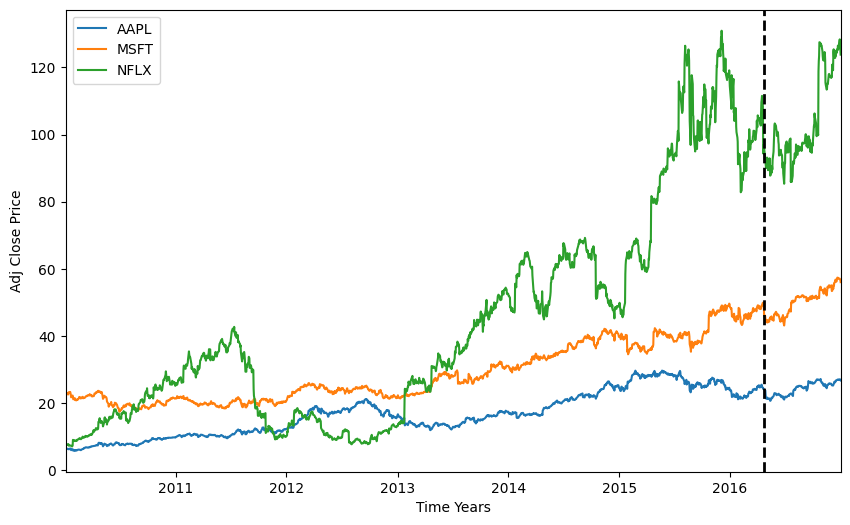

In [14]:
plt.rcParams['figure.figsize'] = (10, 6)
for ticker in tickers:
    plt.plot(data[ticker], label=ticker)

plt.axvline(pd.to_datetime('2016-04-21'), color='black', linestyle='--', lw=2)
plt.legend()
plt.margins(x=0)
plt.ylabel('Adj Close Price')
plt.xlabel('Time Years')


directory_name = 'my_images'
folder_path = os.path.join(os.getcwd(), directory_name)
try:
    os.makedirs(folder_path)
except FileExistsError:
    pass

image_name = 'price_timeseries.png'
image_path = os.path.join(folder_path, image_name)

plt.savefig(image_path, bbox_inches='tight')

In [15]:
import random
from stable_baselines3.common.vec_env import DummyVecEnv

In [16]:
rebalance_period = 1
data_re = data.iloc[::rebalance_period, :]
train_re = train_data.iloc[::rebalance_period, :]
test_re = test_data.iloc[::rebalance_period, :]

In [17]:
timesteps = 25000
iterations = 3
policy = 'MlpPolicy'
length = test_re.shape[0]
stocks = int(test_re.shape[1])


In [18]:
test_re.index.min(), test_re.index.max()

(Timestamp('2016-04-21 00:00:00'), Timestamp('2016-12-30 00:00:00'))

#### PPO

In [24]:
algo = "TD3"
returns_daily_cumulative_ppo = np.zeros([iterations, length])
weights_portfolio_ppo = np.zeros([iterations, length, stocks])

iter = 0
cont = 0

while (iter<iterations):
    print(iter)
    env_train = DummyVecEnv([lambda : StockMarket(df=train_re)])
    model = train(algo, policy, env_train, timesteps, seed=cont, save=False)

    env_test = DummyVecEnv([lambda : StockMarket(df=test_re)])
    test_obs = env_test.reset()

    weights_portfolio_ppo[iter] = np.array(model_prediction(model, test_re, env_test, test_obs))

    #check = np.sum(weights_portfolio_ppo[iter])
    cont += 1
    #if check + 1 != length:
     #   continue

    return_stocks = test_re.pct_change()
    return_stocks_ppo = np.sum(return_stocks.multiply(weights_portfolio_ppo[iter]), axis=1)

    returns_daily_cumulative_ppo[iter] = (1 + return_stocks_ppo).cumprod()

    iter += 1

0


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Training time: 12.473394083976746 minutes
1


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training time: 12.351280609766642 minutes
2


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training time: 12.422827005386353 minutes


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Visualization

Text(0.5, 0, 'Time')

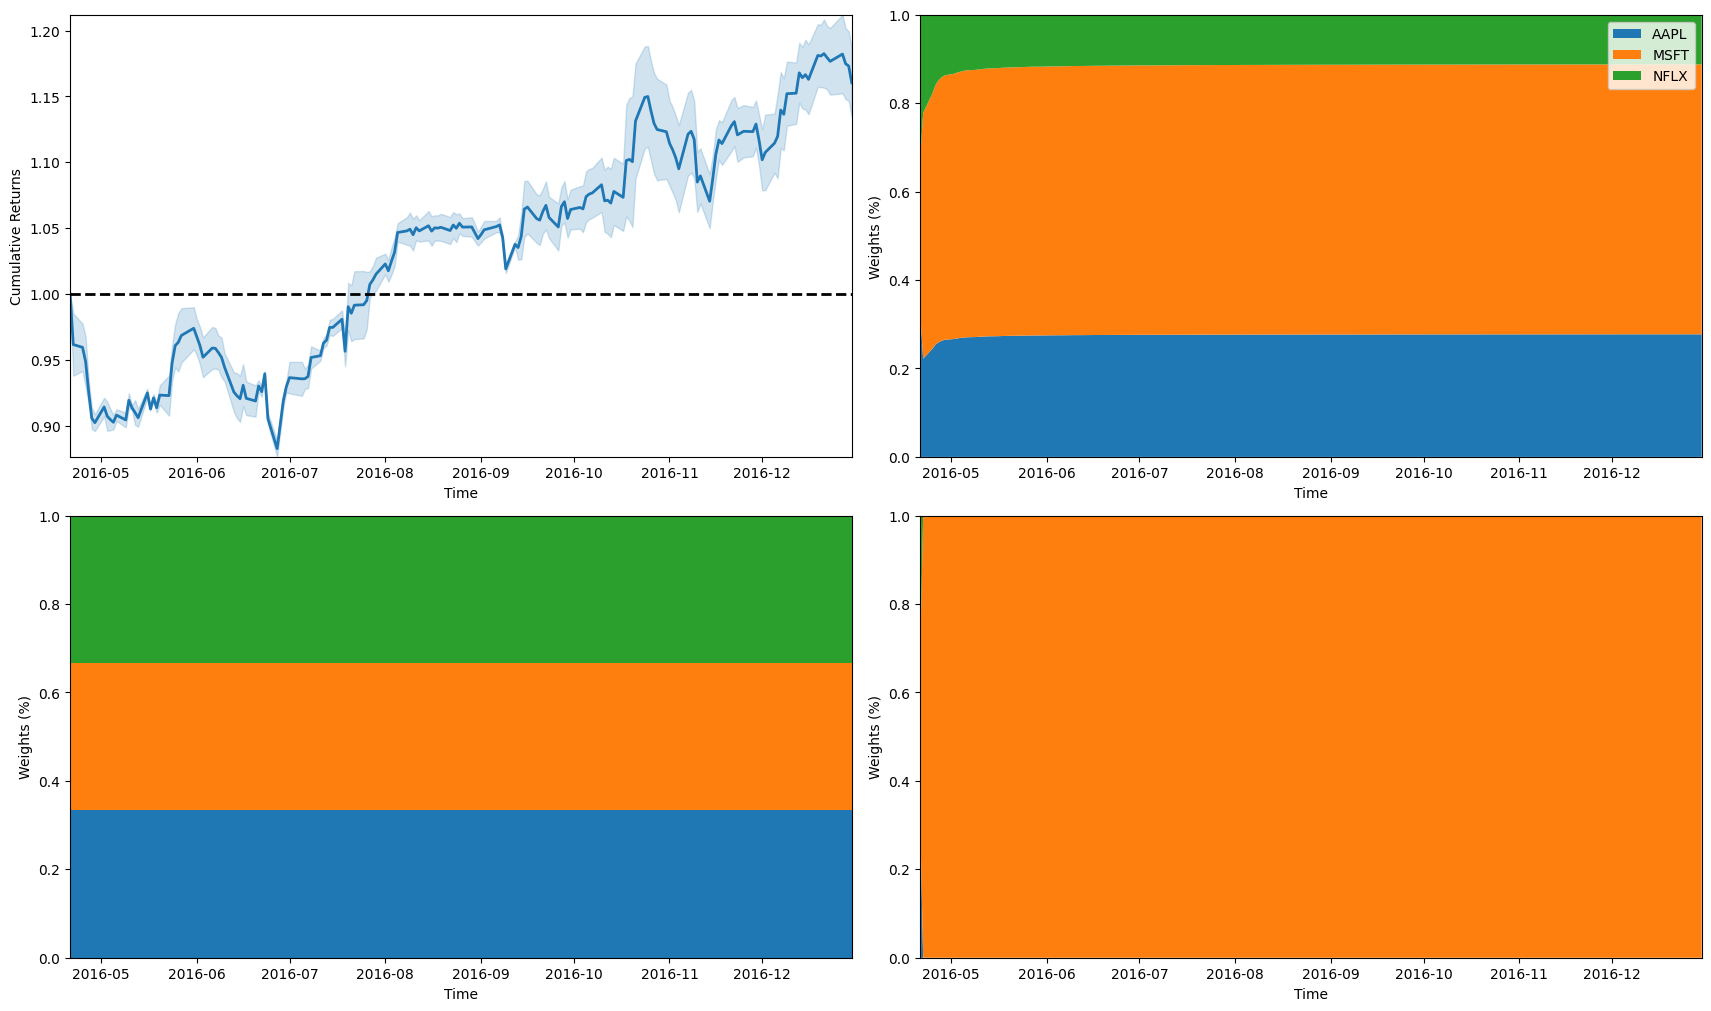

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10), constrained_layout=True)

ppo_mean = np.mean(np.array(returns_daily_cumulative_ppo), axis=0)
ppo_std = np.std(np.array(returns_daily_cumulative_ppo), axis=0)

axs[0, 0].plot(test_re.index, ppo_mean, color='tab:blue', linewidth=2.0)
axs[0, 0].fill_between(test_re.index, ppo_mean - ppo_std, ppo_mean + ppo_std, alpha=0.2, color='tab:blue')
axs[0, 0].margins(x=0)
axs[0, 0].margins(y=0)
axs[0, 0].axhline(1, color='black', linestyle='--', lw=2)
axs[0, 0].set_ylabel('Cumulative Returns')
axs[0, 0 ].set_xlabel('Time')

weights_portfolio_ppo_ = np.mean(np.array(weights_portfolio_ppo), axis=0)
df = pd.DataFrame(weights_portfolio_ppo_, index=test_re.index, columns=tickers)

axs[0, 1].stackplot(test_re.index, df['AAPL'], df['MSFT'], df['NFLX'])
axs[0, 1].legend(tickers, loc='upper right')
axs[0, 1].margins(x=0)
axs[0, 1].margins(y=0)
axs[0, 1].set_ylabel("Weights (%)")
axs[0, 1].set_xlabel("Time")

weights_portfolio_ppo_ = weights_portfolio_ppo[np.argmax(returns_daily_cumulative_ppo[:,-1])]
df = pd.DataFrame (weights_portfolio_ppo_, index = test_re.index, columns = tickers)

axs[1, 0].stackplot(test_re.index, df['AAPL'], df['MSFT'], df['NFLX'])
axs[1, 0].margins(x=0)
axs[1, 0].margins(y=0)
axs[1, 0].set_ylabel("Weights (%)")
axs[1, 0].set_xlabel("Time")

weights_portfolio_ppo_ = weights_portfolio_ppo[np.argmin(returns_daily_cumulative_ppo[:,-1])]
df = pd.DataFrame (weights_portfolio_ppo_, index = test_re.index, columns = tickers)

axs[1, 1].stackplot(test_re.index, df['AAPL'], df['MSFT'], df['NFLX'])
axs[1, 1].margins(x=0)
axs[1, 1].margins(y=0)
axs[1, 1].set_ylabel("Weights (%)")
axs[1, 1].set_xlabel("Time")